In [6]:
# vanilla transformer setup from transformer.py in train-vanilla-transformer, feel free to ignore this cell 
# it's just setup copying from transformer.py to be self-contained
import torch 
from typing import List

ACT2FN = {
    'relu': torch.nn.functional.relu,
    'gelu': torch.nn.functional.gelu,
    'silu': torch.nn.functional.silu,
    'swish': torch.nn.functional.silu,
}

class Attention(torch.nn.Module): # BSD -> BSD
    def __init__(self, D=768, layer_idx=None, head_dim=64, causal=True, device="cuda", gqa=False): 
        super().__init__()
        self.D = D 
        self.head_dim = head_dim
        self.gqa = gqa 
        assert D % head_dim == 0
        self.nheads = D//head_dim
        self.Wq = torch.nn.Linear(D, D)
        self.Wk = torch.nn.Linear(D, D)
        self.Wv = torch.nn.Linear(D, D)
        self.causal = causal 
        self.Wo = torch.nn.Linear(D, D)
        self.device = device
        self.layer_idx = layer_idx

    def forward(self, x: torch.Tensor, kv_cache): # input is [B, S, D] 
        B, S, D = x.shape
        # let's make this multi-head now, ie. make each QKV [B, S, D] --> [B, nh, S, hd]

        Q, K, V = self.Wq(x), self.Wk(x), self.Wv(x) # all [B, S, D]

        Q = Q.view(B, S, self.nheads, self.head_dim).transpose(1,2) # [B, nh, S, hd]
        K = K.view(B, S, self.nheads, self.head_dim).transpose(1,2) 
        V = V.view(B, S, self.nheads, self.head_dim).transpose(1,2)

        # update kv cache 
        layer_idx = self.layer_idx 
        if kv_cache is not None and layer_idx is not None: 
            # its preallocated, just write to the memory of the cache using state of current_length 
            kv_cache.update(layer_idx, K, V)
            K = kv_cache.keys[layer_idx][:, :, :kv_cache.current_length, :]
            V = kv_cache.values[layer_idx][:, :, :kv_cache.current_length, :]

        # [B, nh, S, hd] @ [B, nh, hd, S] -> [B, nh, S, S]
        scale = torch.sqrt(torch.tensor(self.head_dim, dtype=Q.dtype, device=self.device))
        logits = (Q @ K.transpose(-2, -1)) / scale
        if self.causal:
            mask = torch.triu(torch.ones_like(logits), diagonal=1).bool()
            logits_masked = logits.masked_fill(mask, float('-inf'))
        else:
            logits_masked = logits

        A = torch.nn.functional.softmax(logits_masked, dim=-1) # [B, nh, S, S]
        
        preout = torch.einsum('bnxy,bnyd->bnxd', A, V) # [B, nh, S, S] @ [B, nh, S, hd] -> [B, nh, S, hd]
        preout = preout.transpose(1, 2).reshape(B, S, -1) # [B, nh, S, hd] -> [B, S, nh * hd]
        
        out = self.Wo(preout) # [B, S, D]
        return out # [B, S, D]

class MLP(torch.nn.Module): 
    def __init__(self, D, hidden_multiplier=4, act='swish', device=None): 
        super().__init__()
        self.D = D
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.up_proj = torch.nn.Linear(D, D*hidden_multiplier)
        self.down_proj = torch.nn.Linear(D*hidden_multiplier, D)
        self.act = ACT2FN[act]

    def forward(self, x): # BSD -> BSD automatically on last dim 
        return self.down_proj(self.act(self.up_proj(x)))

class LN(torch.nn.Module): 
    def __init__(self, D, eps=1e-9, device=None): 
        super().__init__()
        self.D = D 
        self.eps = eps
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.mean_scale = torch.nn.Parameter(torch.zeros(D))
        self.std_scale = torch.nn.Parameter(torch.ones(D))

    def forward(self, x): # x is [B, S, D]
        mean = x.mean(dim=-1, keepdim=True) # [B, S, 1]
        std = (x.var(dim=-1, keepdim=True) + self.eps)**0.5 # [B, S, 1]
        x_norm = (x - mean)/(std) 
        return x_norm * self.std_scale + self.mean_scale

class TransformerLayer(torch.nn.Module): 
    def __init__(self, D, gqa=False, device=None): 
        super().__init__()
        self.D = D 
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.attn = Attention(D, gqa=gqa, device=self.device)
        self.mlp = MLP(D, device=self.device)
        self.ln1 = LN(D, device=self.device)
        self.ln2 = LN(D, device=self.device)  
    
    def forward(self, x, kv_cache=None): # x is BSD
        ln1_out = self.ln1(x)
        attn_out = self.attn(ln1_out, kv_cache=kv_cache)
        x = x + attn_out
        ln2_out = self.ln2(x)
        mlp_out = self.mlp(ln2_out)
        x = x + mlp_out
        return x 

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, max_seq_len, D, device=None):
        super().__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pos_embedding = torch.nn.Parameter(torch.randn(max_seq_len, D))
    
    def forward(self, x): # x is [B, S, D]
        B, S, D = x.shape
        return x + self.pos_embedding[:S] # Broadcasting handles batch dimension

class EmbeddingLayer(torch.nn.Module): 
    # this is just a lookup table 
    def __init__(self, vocab_size, D, device=None): 
        super().__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embedding = torch.nn.Parameter(torch.randn(vocab_size, D))

    def forward(self, x): 
        return self.embedding[x]

class UnembeddingLayer(torch.nn.Module): 
    # this is just a lookup table that maps embeddings back to logits
    def __init__(self, vocab_size, D, device=None): 
        super().__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.unembedding = torch.nn.Linear(D, vocab_size)

    def forward(self, x): # x is [B, S, D]
        # Return logits of shape [B, S, vocab_size]
        return self.unembedding(x)

class Transformer(torch.nn.Module): 
    def __init__(self, depth, hidden_dim, vocab_size, max_seq_len=16384, device=None, gqa=False): 
        super().__init__()
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.emb = EmbeddingLayer(vocab_size, hidden_dim, device=device)
        self.pos_emb = PositionalEmbedding(max_seq_len, hidden_dim, device=device)
        self.unemb = UnembeddingLayer(vocab_size, hidden_dim, device=device)
        self.gqa = gqa 
        self.layers = torch.nn.ModuleList([TransformerLayer(hidden_dim, gqa, device=device) for _ in range(depth)])
        for i, layer in enumerate(self.layers):
            layer.attn.layer_idx = i  
        self.device = device

    def forward(self, x, kv_cache=None):
        x = self.emb(x)
        if kv_cache is not None:
            # When decoding, only add positional embeddings for the new tokens.
            pos_offset = kv_cache.current_length
            pos_emb = self.pos_emb.pos_embedding[pos_offset: pos_offset + x.size(1)].unsqueeze(0)
            x = x + pos_emb
        else:
            x = self.pos_emb(x)
        for i, layer in enumerate(self.layers):
            x = layer(x, kv_cache=kv_cache)
        x = self.unemb(x)
        return x

In [ ]:
''' 
KV CACHE FUNDAMENTALS. WHAT EVEN IS THIS BOI? 
    - Basically its just a preallocated tensor that we fill up during autoregressive inference ("decoding")
        - We use it to avoid recomputing (K, V)
    - It naturally leads to a two-stage interpretation fo inference 
        - The first stage takes in a full prompt and populates the empty cache, this is called "prefill" 
        - The second stage passes in ONLY ONE TOKEN IN THE FORWARD PASS AT A TIME, 
            because the information from all past tokens IS ENTIRELY CAPTURED IN THE KV CACHE 
            - You can think of the KV cache as the "state" of a transformer, ie. the sufficient summary statistic 
            of all past tokens to generate the next token. Unlike RNN/SSM state, its size grows over time
            (hence why Transformers perform better, they do zero compression of their inputs, but also take more memory)
        - The second stage is called decoding, and we basically add [k_t, v_t] to update the cache
        as we do a forward with each token one at a time, and then use the updated cache as our K, V matrices
        for attention. 
    - Common question, why don't we cache queries, Q? 
        - Answer: this is a good question and important to make sure you understand. The reason is because KV cache is a 
        SUFFICIENT SUMMARY STATISTIC OF THE PAST TOKENS, and we DO NOT need to know the queries of past tokens to compute 
        the attention pattern of a SINGLE NEW TOKEN during decoding, only the query of the new token. 
        However, we DO need the keys and values of previous tokens, as the addition to the attention matrix for this 
        new token will be something like (q_t @ all_past_keys.T) @ all_past_values. 
'''

In [ ]:
# kv cache implementation and profiling
class KVCache:
    """
    minimal kv cache for transformer models that preallocates memory for k/v pairs.
    k/v tensors have shape: [batch_size, num_heads, max_seq_len, head_dim]
    """
    def __init__(self, num_layers: int, batch_size: int, num_heads: int, head_dim: int, max_seq_len: int, device='cuda'):
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.max_seq_len = max_seq_len
        self.device = device
        self.current_length = 0
        # preallocate cache memory for each layer
        self.keys = [
            torch.empty(batch_size, num_heads, max_seq_len, head_dim, device=device)
            for _ in range(num_layers)
        ]
        self.values = [
            torch.empty(batch_size, num_heads, max_seq_len, head_dim, device=device)
            for _ in range(num_layers)
        ]

    def update(self, layer: int, new_keys: torch.Tensor, new_values: torch.Tensor):
        """
        updates cache for a layer with new k/v tensors of shape:
        [batch_size, num_heads, token_count, head_dim]
        """
        seq_offset = self.current_length
        token_count = new_keys.size(2)
        self.keys[layer][:, :, seq_offset:seq_offset + token_count, :] = new_keys
        self.values[layer][:, :, seq_offset:seq_offset + token_count, :] = new_values


class TransformerGenerator:
    """
    fast autoregressive inference using preallocated kv cache. model must accept
    'kv_cache' arg in forward() to load/append k/v pairs from cache
    """
    def __init__(self, model: Transformer, max_seq_len: int=4096):
        self.model = model
        self.device = next(model.parameters()).device
        self.max_seq_len = max_seq_len
        self.kv_cache = None

    def _initialize_cache(self, batch_size: int):
        # extract attn params from first layer to set up cache dims
        first_layer = self.model.layers[0]
        attn = first_layer.attn
        
        num_heads = attn.num_kv_heads if (hasattr(attn, 'gqa') and attn.gqa) else attn.nheads
        head_dim = attn.head_dim
        
        self.kv_cache = self.model.kv_cache = KVCache(
            self.model.depth, 
            batch_size, 
            num_heads,
            head_dim,
            self.max_seq_len, 
            self.device
        )

    def _prefill(self, prompt: List[int]):
        # process initial prompt (shape [1, seq_len]) to fill kv cache
        prompt_tensor = torch.tensor(prompt, device=self.device).unsqueeze(0)
        batch_size = prompt_tensor.size(0)
        self._initialize_cache(batch_size)
        _ = self.model(prompt_tensor, kv_cache=self.kv_cache)
        self.kv_cache.current_length = prompt_tensor.size(1)
        return self.kv_cache

    def generate(self, prompt: List[int], max_new_tokens: int):
        """
        generates tokens autoregressively given a prompt
        returns: list[int] with prompt + new tokens
        """
        kv_cache = self._prefill(prompt)
        generated = list(prompt)
        for _ in range(max_new_tokens):
            # feed last token through model, shape [1,1]
            input_tensor = torch.tensor([[generated[-1]]], device=self.device)
            logits = self.model(input_tensor, kv_cache=kv_cache)
            next_token = int(torch.argmax(logits[:, -1, :], dim=-1).item())
            generated.append(next_token)
            kv_cache.current_length += 1
        return generated


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [08:41<00:00, 130.46s/it]


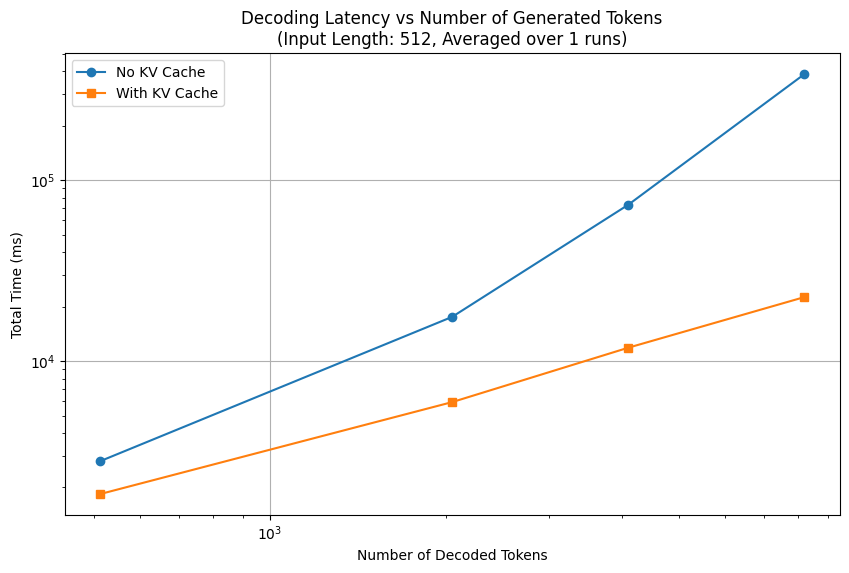


Average time per decoded token (averaged over 1 runs):
----------------------------------------------------
Decoding Method | Tokens Decoded | Avg ms/token
----------------------------------------------------
No KV Cache     |            512 |         5.45
With KV Cache   |            512 |         3.59
----------------------------------------------------
No KV Cache     |           2048 |         8.57
With KV Cache   |           2048 |         2.90
----------------------------------------------------
No KV Cache     |           4096 |        17.87
With KV Cache   |           4096 |         2.89
----------------------------------------------------
No KV Cache     |           8192 |        47.13
With KV Cache   |           8192 |         2.76
----------------------------------------------------


In [8]:
import os
import sys
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# this profiling takes ~10min on a single H100, you can reduce any of the below to make it faster 
# (hidden_dim, num_layers, input_seq_len, num_decode_tokens, n_runs)
vocab_size = 256
hidden_dim = 512
n_layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Transformer(depth=n_layers, hidden_dim=hidden_dim, vocab_size=vocab_size, device=device)
model = model.to(device)
model.eval()

generator = TransformerGenerator(model)

input_seq_len = 512
num_decode_tokens = [512, 2048, 4096, 8192]
decode_times_no_kv = []
decode_times_kv = []
n_runs = 1

with torch.no_grad():
    for n_tokens in tqdm(num_decode_tokens):
        batch_size = 1
        times_for_this_n_no_kv = []
        times_for_this_n_kv = []

        for _ in range(n_runs):
            prompt_tensor = torch.randint(0, vocab_size, (batch_size, input_seq_len)).to(device)
            prompt_list = prompt_tensor.squeeze(0).tolist()

            x = prompt_tensor.clone()
            start_time_no_kv = time.time()
            for _ in range(n_tokens):
                logits = model(x)
                # get next token prediction [B, 1]
                next_token = torch.argmax(logits[:, -1:, :], dim=-1)
                x = torch.cat([x, next_token], dim=1)
            torch.cuda.synchronize()
            end_time_no_kv = time.time()
            times_for_this_n_no_kv.append((end_time_no_kv - start_time_no_kv) * 1000)

            start_time_kv = time.time()
            _ = generator.generate(prompt_list, n_tokens)
            torch.cuda.synchronize()
            end_time_kv = time.time()
            times_for_this_n_kv.append((end_time_kv - start_time_kv) * 1000)

        avg_time_no_kv = np.mean(times_for_this_n_no_kv)
        decode_times_no_kv.append(avg_time_no_kv)
        avg_time_kv = np.mean(times_for_this_n_kv)
        decode_times_kv.append(avg_time_kv)

plt.figure(figsize=(10, 6))
plt.plot(num_decode_tokens, decode_times_no_kv, marker='o', label='No KV Cache')
plt.plot(num_decode_tokens, decode_times_kv, marker='s', label='With KV Cache')
plt.xlabel('Number of Decoded Tokens')
plt.ylabel('Total Time (ms)')
plt.title(f'Decoding Latency vs Number of Generated Tokens\n(Input Length: {input_seq_len}, Averaged over {n_runs} runs)')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

print(f"\nAverage time per decoded token (averaged over {n_runs} runs):")
print("----------------------------------------------------")
print("Decoding Method | Tokens Decoded | Avg ms/token")
print("----------------------------------------------------")
for n_tokens, total_time_no_kv, total_time_kv in zip(num_decode_tokens, decode_times_no_kv, decode_times_kv):
    avg_per_token_no_kv = total_time_no_kv / n_tokens if n_tokens > 0 else 0
    avg_per_token_kv = total_time_kv / n_tokens if n_tokens > 0 else 0
    print(f"No KV Cache     | {n_tokens:14d} | {avg_per_token_no_kv:12.2f}")
    print(f"With KV Cache   | {n_tokens:14d} | {avg_per_token_kv:12.2f}")
    print("----------------------------------------------------")

# Hurray! We can see that without KV cache, decoding latency is nonlinear (it will be quadratic if you zoom out more)
# but with KV cache, decoding latency is linear in sequence length, so this is a O(S) big win!